In [19]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [20]:
train = pd.read_csv("data/train.csv", parse_dates=["timestamp"])
test = pd.read_csv("data/test.csv", parse_dates=["timestamp"])
macro = pd.read_csv("data/macro.csv", parse_dates=["timestamp"])

In [21]:
y_train = train["price_doc"]
x_train = train.drop(["timestamp", "price_doc", "id"], axis=1)

In [22]:
# transform non-numerical variables
for c in x_train.columns:
    if x_train[c].dtype == "object":
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[c].values)) 
        x_train[c] = lbl.transform(list(x_train[c].values))

# replace missing values with mean values
for c in x_train.columns:
    x_train[c].fillna(x_train[c].mean(), inplace=True)

In [41]:
x_test = test.drop(["timestamp", "id"], axis=1)

# transform non-numerical variables
for c in x_test.columns:
    if x_test[c].dtype == "object":
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values)) 
        x_test[c] = lbl.transform(list(x_test[c].values))
        
# replace missing values with mean values
for c in x_test.columns:
    x_test[c].fillna(x_test[c].mean(), inplace=True)

In [42]:
# join macro with traindata
train_macro = pd.merge(train, macro, how="left", on="timestamp")
test_macro = pd.merge(test, macro, how="left", on="timestamp")

In [43]:
# add price to macro data and filter out
test_macro = test_macro[np.append(macro.columns.values, "id")].copy()

# remove columns that are completly null
test_macro.dropna(axis=1, how="all", inplace=True)
train_macro = train_macro[np.append(test_macro.columns.values, "price_doc")]

In [44]:
y_train_macro = train_macro["price_doc"]
x_train_macro = train_macro.drop(["timestamp", "price_doc"], axis=1)

# transform non-numerical variables
for c in x_train_macro.columns:
    if x_train_macro[c].dtype == "object":
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train_macro[c].values)) 
        x_train_macro[c] = lbl.transform(list(x_train_macro[c].values))
        
# replace missing values with mean values
for c in x_train_macro.columns:
    x_train_macro[c].fillna(x_train_macro[c].mean(), inplace=True)

In [45]:
x_test_macro = test_macro.drop(["timestamp"], axis=1)

# transform non-numerical variables
for c in x_test_macro.columns:
    if x_test_macro[c].dtype == "object":
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test_macro[c].values)) 
        x_test_macro[c] = lbl.transform(list(x_test_macro[c].values))
        
# replace missing values with mean values
for c in x_test_macro.columns:
    x_test_macro[c].fillna(x_test_macro[c].mean(), inplace=True)

In [53]:
x_train_full = pd.concat([x_train, x_train_macro], axis=1)
x_test_full = pd.concat([x_test, x_test_macro], axis=1)

In [54]:
# reset index
x_train_full.set_index("id", inplace=True)
x_test_full.set_index("id", inplace=True)

In [55]:
xgb_params = {
    "eta": 0.05,
    "max_depth": 5,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "objective": "reg:linear",
    "eval_metric": "rmse",
    "silent": 1,
    "seed":42
}

In [60]:
dtrain = xgb.DMatrix(x_train_full, y_train)

In [61]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                   verbose_eval=50, show_stdv=False)

[0]	train-rmse:8.20523e+06	test-rmse:8.20993e+06
[50]	train-rmse:2.51858e+06	test-rmse:2.91301e+06
[100]	train-rmse:2.17077e+06	test-rmse:2.72686e+06
[150]	train-rmse:2.04553e+06	test-rmse:2.68511e+06
[200]	train-rmse:1.95421e+06	test-rmse:2.66473e+06
[250]	train-rmse:1.87985e+06	test-rmse:2.65043e+06
[300]	train-rmse:1.81434e+06	test-rmse:2.64097e+06
[350]	train-rmse:1.75428e+06	test-rmse:2.63471e+06
[400]	train-rmse:1.6974e+06	test-rmse:2.63122e+06
[450]	train-rmse:1.64907e+06	test-rmse:2.6297e+06


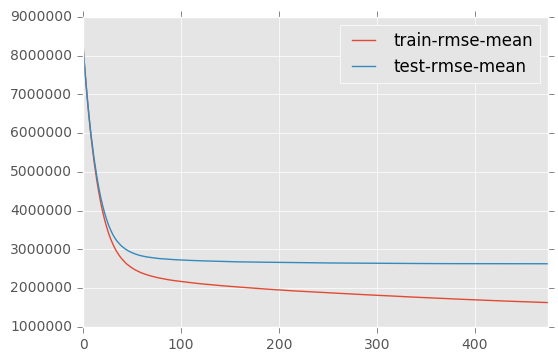

In [62]:
cv_output[["train-rmse-mean", "test-rmse-mean"]].plot()
pass

In [63]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

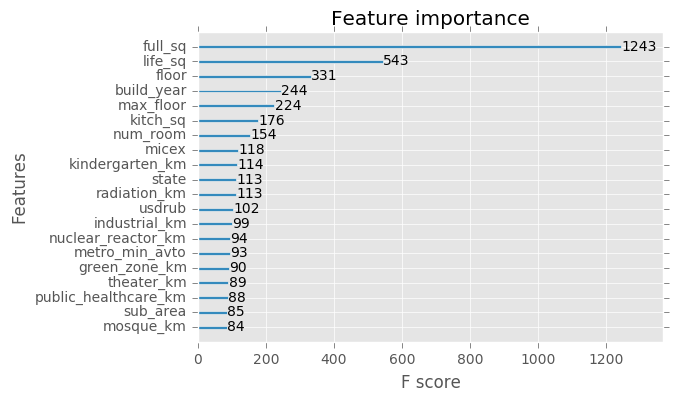

In [64]:
xgb.plot_importance(model, max_num_features=20)

In [65]:
pred = model.predict(dtrain)

In [66]:
error = np.mean(abs(pred - y_train)) / len(y_train)

In [67]:
n = 1 / len(y_train)
rmsle = np.sqrt(1/n * np.sum(np.power(np.log(pred + 1) - np.log(y_train.values + 1), 2)))

In [68]:
print("RMSLE: {rmsle}, Error: {error}".format(rmsle=rmsle, error=error))

RMSLE: 12929.003217950514, Error: 36.34626791317075


In [78]:
dtest = xgb.DMatrix(x_test_full)

In [79]:
y_predict = model.predict(dtest)

In [80]:
output = pd.DataFrame({"id": x_test_full.index, "price_doc": y_predict})

In [81]:
output.to_csv("submissions_macro.csv", index=False)

# notes
- normalization doesn't work well
- gpd data doesn't help much but makes the model more worse